# Фильтр Блума со счетом
Элемент добавляется путем вычисления нескольких хэшей и установки соответствующих битов в массиве.

В фильтре со счетом вместо битов используются счетчики, чтобы поддерживать удаление.

Для элемента вычисляются хэши, и соответствующие счетчики увеличиваются.

Если все счетчики для элемента больше нуля, элемент, вероятно, в множестве (возможны ложные срабатывания).

Ложные срабатывания возникают из-за коллизий хэшей. Вероятность зависит от размера массива и числа хэш-функций. Но ложных отрицаний нет.

In [70]:

import matplotlib.pyplot as plt
import mmh3

class CountingBloomFilter:
    def __init__(self, size, hash_count):
        self.size = size
        self.hash_count = hash_count
        self.counters = [0] * size

    def add(self, item):
        for seed in range(self.hash_count):
            index = mmh3.hash(item, seed) % self.size
            self.counters[index] += 1
            
    def contains(self, item):
        for seed in range(self.hash_count):
            index = mmh3.hash(item, seed) % self.size
            if self.counters[index] == 0:
                return False
        return True
    
    def union(bloom_filter1, bloom_filter2):
        new_filter = CountingBloomFilter(bloom_filter1.size, bloom_filter1.hash_count)
        for i in range(bloom_filter1.size):
            new_filter.counters[i] = bloom_filter1.counters[i] + bloom_filter2.counters[i]
        return new_filter

    def intersection(bloom_filter1, bloom_filter2):
        new_filter = CountingBloomFilter(bloom_filter1.size, bloom_filter1.hash_count)
        for i in range(bloom_filter1.size):
            new_filter.counters[i] = min(bloom_filter1.counters[i], bloom_filter2.counters[i])
        return new_filter

In [ ]:
def false_positive_rate(bloom_filter, num_elements, num_tests):
    
    for i in range(num_elements):
        bloom_filter.add(f"item_{i}")

    false_positives = 0
    for i in range(num_elements, num_elements + num_tests):
        if bloom_filter.contains(f"item_{i}"):
            false_positives += 1
            
    return false_positives / num_tests

def evaluate_false_positive_rates(size_range, hash_count_range, num_elements, num_tests):
    results = {}
    for size in size_range:
        for hash_count in hash_count_range:
            bloom_filter = CountingBloomFilter(size, hash_count)
            rate = false_positive_rate(bloom_filter, num_elements, num_tests)
            results[(size, hash_count)] = rate
    return results

def plot_false_positive_rates(results):
    sizes = sorted(set(size for size, _ in results.keys()))
    hash_counts = sorted(set(hash_count for _, hash_count in results.keys()))

    for hash_count in hash_counts:
        rates = [results[(size, hash_count)] for size in sizes]
        plt.plot(sizes, rates, label=f"Count: {hash_count}")

    plt.xlabel("Размер фильтра Блума")
    plt.ylabel("Вероятность ложного срабатывания")
    plt.legend()
    plt.show()

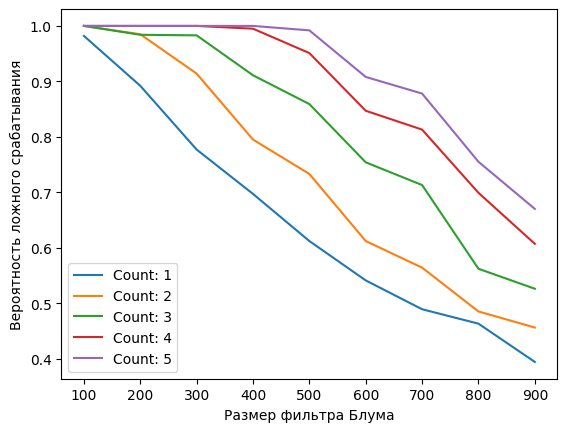

In [73]:
size_range = range(100, 1000, 100)
hash_count_range = range(1, 6)
num_elements = 500
num_tests = 1000

results = evaluate_false_positive_rates(size_range, hash_count_range, num_elements, num_tests)
plot_false_positive_rates(results)

In [72]:
bf1 = CountingBloomFilter(size=1000, hash_count=3)
bf2 = CountingBloomFilter(size=1000, hash_count=3)

bf1.add("1000")
bf1.add("1001")
bf1.add("1010")

bf2.add("1001")
bf2.add("1010")
bf2.add("1100")

print("1000 в bf1:", bf1.contains("1000")) # True
print("1100 в bf1:", bf1.contains("1100"), "\n") # False

bf_union = CountingBloomFilter.union(bf1, bf2)
print("1001 в bf_union:", bf_union.contains("1000")) # True
print("1100 в bf_union:", bf_union.contains("1100")) # True
print("1111 в bf_union:", bf_union.contains("1111"), "\n") # False

bf_intersection = CountingBloomFilter.intersection(bf1, bf2)
print("1001 в bf_intersection:", bf_intersection.contains("1001")) # True
print("1100 в bf_intersection:", bf_intersection.contains("1100"))  # False

1000 в bf1: True
1100 в bf1: False 

1001 в bf_union: True
1100 в bf_union: True
1111 в bf_union: False 

1001 в bf_intersection: True
1100 в bf_intersection: False
